<a href="https://colab.research.google.com/github/Skyleriscool/Thyroid_Diff/blob/main/EPA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Run the code below to import the necessary libraries.**

In [5]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [6]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, accuracy_score
import scipy.stats as stats
import numpy as np

In [7]:
df = pd.read_csv("Thyroid_Diff.csv")

X = pd.DataFrame(df['Age']) # Features
y = df["Recurred"]  # Target values
df.head()

,Age,Gender,Smoking,Hx Smoking,Hx Radiothreapy,Thyroid Function,Physical Examination,Adenopathy,Pathology,Focality,Risk,T,N,M,Stage,Response,Recurred
0,27,F,No,No,No,Euthyroid,Single nodular goiter-left,No,Micropapillary,Uni-Focal,Low,T1a,N0,M0,I,Indeterminate,No
1,34,F,No,Yes,No,Euthyroid,Multinodular goiter,No,Micropapillary,Uni-Focal,Low,T1a,N0,M0,I,Excellent,No
2,30,F,No,No,No,Euthyroid,Single nodular goiter-right,No,Micropapillary,Uni-Focal,Low,T1a,N0,M0,I,Excellent,No
3,62,F,No,No,No,Euthyroid,Single nodular goiter-right,No,Micropapillary,Uni-Focal,Low,T1a,N0,M0,I,Excellent,No
4,62,F,No,No,No,Euthyroid,Multinodular goiter,No,Micropapillary,Multi-Focal,Low,T1a,N0,M0,I,Excellent,No


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 383 entries, 0 to 382
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Age                   383 non-null    int64 
 1   Gender                383 non-null    object
 2   Smoking               383 non-null    object
 3   Hx Smoking            383 non-null    object
 4   Hx Radiothreapy       383 non-null    object
 5   Thyroid Function      383 non-null    object
 6   Physical Examination  383 non-null    object
 7   Adenopathy            383 non-null    object
 8   Pathology             383 non-null    object
 9   Focality              383 non-null    object
 10  Risk                  383 non-null    object
 11  T                     383 non-null    object
 12  N                     383 non-null    object
 13  M                     383 non-null    object
 14  Stage                 383 non-null    object
 15  Response              383 non-null    ob

In [9]:
df.describe()

,Age
count,383.000000
mean,40.866841
std,15.134494
min,15.000000
25%,29.000000
50%,37.000000
75%,51.000000
max,82.000000


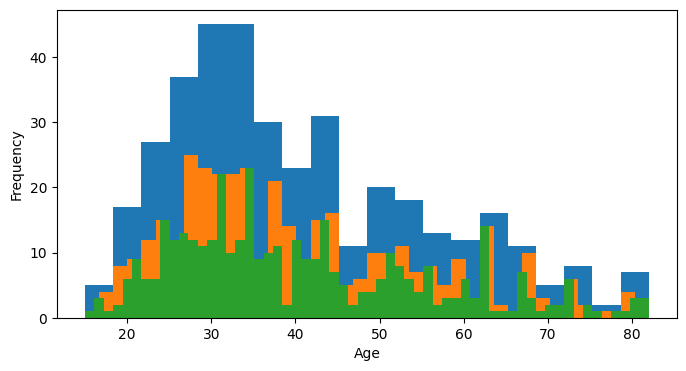

In [10]:
ages = df["Age"]

plt.figure(figsize=(8, 4))
plt.hist(ages, bins=20)
plt.hist(ages, bins=40)
plt.hist(ages, bins=60)
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.show()

In [11]:
prepared_df = df.copy(deep=True)
patient_df = df
print(prepared_df)
def yes_no_categorical_to_binary(df_col):
  return(df_col.map({"Yes": 1, "No": 0}))

def one_hot_encode(df_col, value_to_encode):
  return((df_col == value_to_encode).map({True: 1, False: 0}))

prepared_df["Gender"] = df["Gender"].map({"M": 1, "F": 0})
# Smoking
prepared_df["Smoking"] = yes_no_categorical_to_binary(patient_df["Smoking"])

# Hx Smoking
prepared_df["Hx Smoking"] = yes_no_categorical_to_binary(patient_df["Hx Smoking"])

# TODO: Fix this dataset's typo
# Hx Radiotherapy
prepared_df["Hx Radiothreapy"] = yes_no_categorical_to_binary(patient_df["Hx Radiothreapy"])

# Thyroid Function - These appear to be mostly progressive
# TODO: This seems like a bad way to do this
prepared_df["Thyroid Function"] = patient_df["Thyroid Function"].map({
    "Euthyroid": 0, # Proper functioning
    "Subclinical Hyperthyroidism": 1, # Slight overfunction
    "Subclinical Hypothyroidism": -1, # Slight underfunction
    "Clinical Hyperthyroidism": -2, # Overfunction
    "Clinical Hypothyroidism": 2, # Underfunction
  })

# Physical Examination
prepared_df["Physical Examination"] = patient_df["Physical Examination"].map({
    "Normal": 0,
    "Single nodular goiter-left": 1, # TODO: This also seems like poor practice
    "Single nodular goiter-right": 1,
    "Multinodular goiter": 2, # Many nodules
    "Diffuse goiter": 3 # Large nodule
  })

# Adenopathy - These are mutually exclusive
prepared_df = prepared_df.drop("Adenopathy", axis=1)
prepared_df["Adenopathy (Is No)"] = one_hot_encode(patient_df["Adenopathy"], "No")
prepared_df["Adenopathy (Is Right)"] = one_hot_encode(patient_df["Adenopathy"], "Right")
prepared_df["Adenopathy (Is Extensive)"] = one_hot_encode(patient_df["Adenopathy"], "Extensive")
prepared_df["Adenopathy (Is Left)"] = one_hot_encode(patient_df["Adenopathy"], "Left")
prepared_df["Adenopathy (Is Bilateral)"] = one_hot_encode(patient_df["Adenopathy"], "Bilateral")
prepared_df["Adenopathy (Is Posterior)"] = one_hot_encode(patient_df["Adenopathy"], "Posterior")

# Pathology - These are mutually exclusive
prepared_df = prepared_df.drop("Pathology", axis=1)
prepared_df["Pathology (Is Micropapillary)"] = one_hot_encode(patient_df["Pathology"], "Micropapillary")
prepared_df["Pathology (Is Papillary)"] = one_hot_encode(patient_df["Pathology"], "Papillary")
prepared_df["Pathology (Is Follicular)"] = one_hot_encode(patient_df["Pathology"], "Follicular")
prepared_df["Pathology (Is Hurthel cell)"] = one_hot_encode(patient_df["Pathology"], "Hurthel cell")

# Focality
prepared_df = prepared_df.drop("Focality", axis=1)
prepared_df["Focality (Is Multi-Focal?)"] = patient_df["Focality"].map({"Uni-Focal": 0, "Multi-Focal": 1})

# Risk
prepared_df["Risk"] = patient_df["Risk"].map({"Low": 1, "Intermediate": 2, "High": 3})

# T - This is progressive
prepared_df["T"] = patient_df["T"].map({"T1a": 1, "T1b": 2, "T2": 3, "T3a": 4, "T3b": 5, "T4a": 6, "T4b": 7})

# N - This is progressive
prepared_df["N"] = patient_df["N"].map({"N0": 0, "N1a": 1, "N1b": 2})

# M
prepared_df["M"] = patient_df["M"].map({"M0": 0, "M1": 1})

# Stage
prepared_df["Stage"] = patient_df["Stage"].map({"I": 1, "II": 2, "III": 3, "IVA": 4, "IVB": 5})

# Response - These are mutually exclusive
prepared_df = prepared_df.drop("Response", axis=1)
prepared_df["Response (Is Indeterminate)"] = one_hot_encode(patient_df["Response"], "Indeterminate")
prepared_df["Response (Is Excellent)"] = one_hot_encode(patient_df["Response"], "Excellent")
prepared_df["Response (Is Structural Incomplete)"] = one_hot_encode(patient_df["Response"], "Structural Incomplete")
prepared_df["Response (Is Biochemical Incomplete)"] = one_hot_encode(patient_df["Response"], "Biochemical Incomplete")

# Recurred
prepared_df["Recurred"] = yes_no_categorical_to_binary(patient_df["Recurred"])

     Age Gender Smoking Hx Smoking Hx Radiothreapy          Thyroid Function  \
0     27      F      No         No              No                 Euthyroid   
1     34      F      No        Yes              No                 Euthyroid   
2     30      F      No         No              No                 Euthyroid   
3     62      F      No         No              No                 Euthyroid   
4     62      F      No         No              No                 Euthyroid   
..   ...    ...     ...        ...             ...                       ...   
378   72      M     Yes        Yes             Yes                 Euthyroid   
379   81      M     Yes         No             Yes                 Euthyroid   
380   72      M     Yes        Yes              No                 Euthyroid   
381   61      M     Yes        Yes             Yes  Clinical Hyperthyroidism   
382   67      M     Yes         No              No                 Euthyroid   

            Physical Examination Adenop

In [12]:
def evaluate(X, y):
  #Do evaluation
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

  # Initialize and fit the model
  model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=200)
  model.fit(X_train, y_train)

  # Make predictions
  y_pred = model.predict(X_test)

  # Evaluate the model
  accuracy = accuracy_score(y_test, y_pred)
  return accuracy

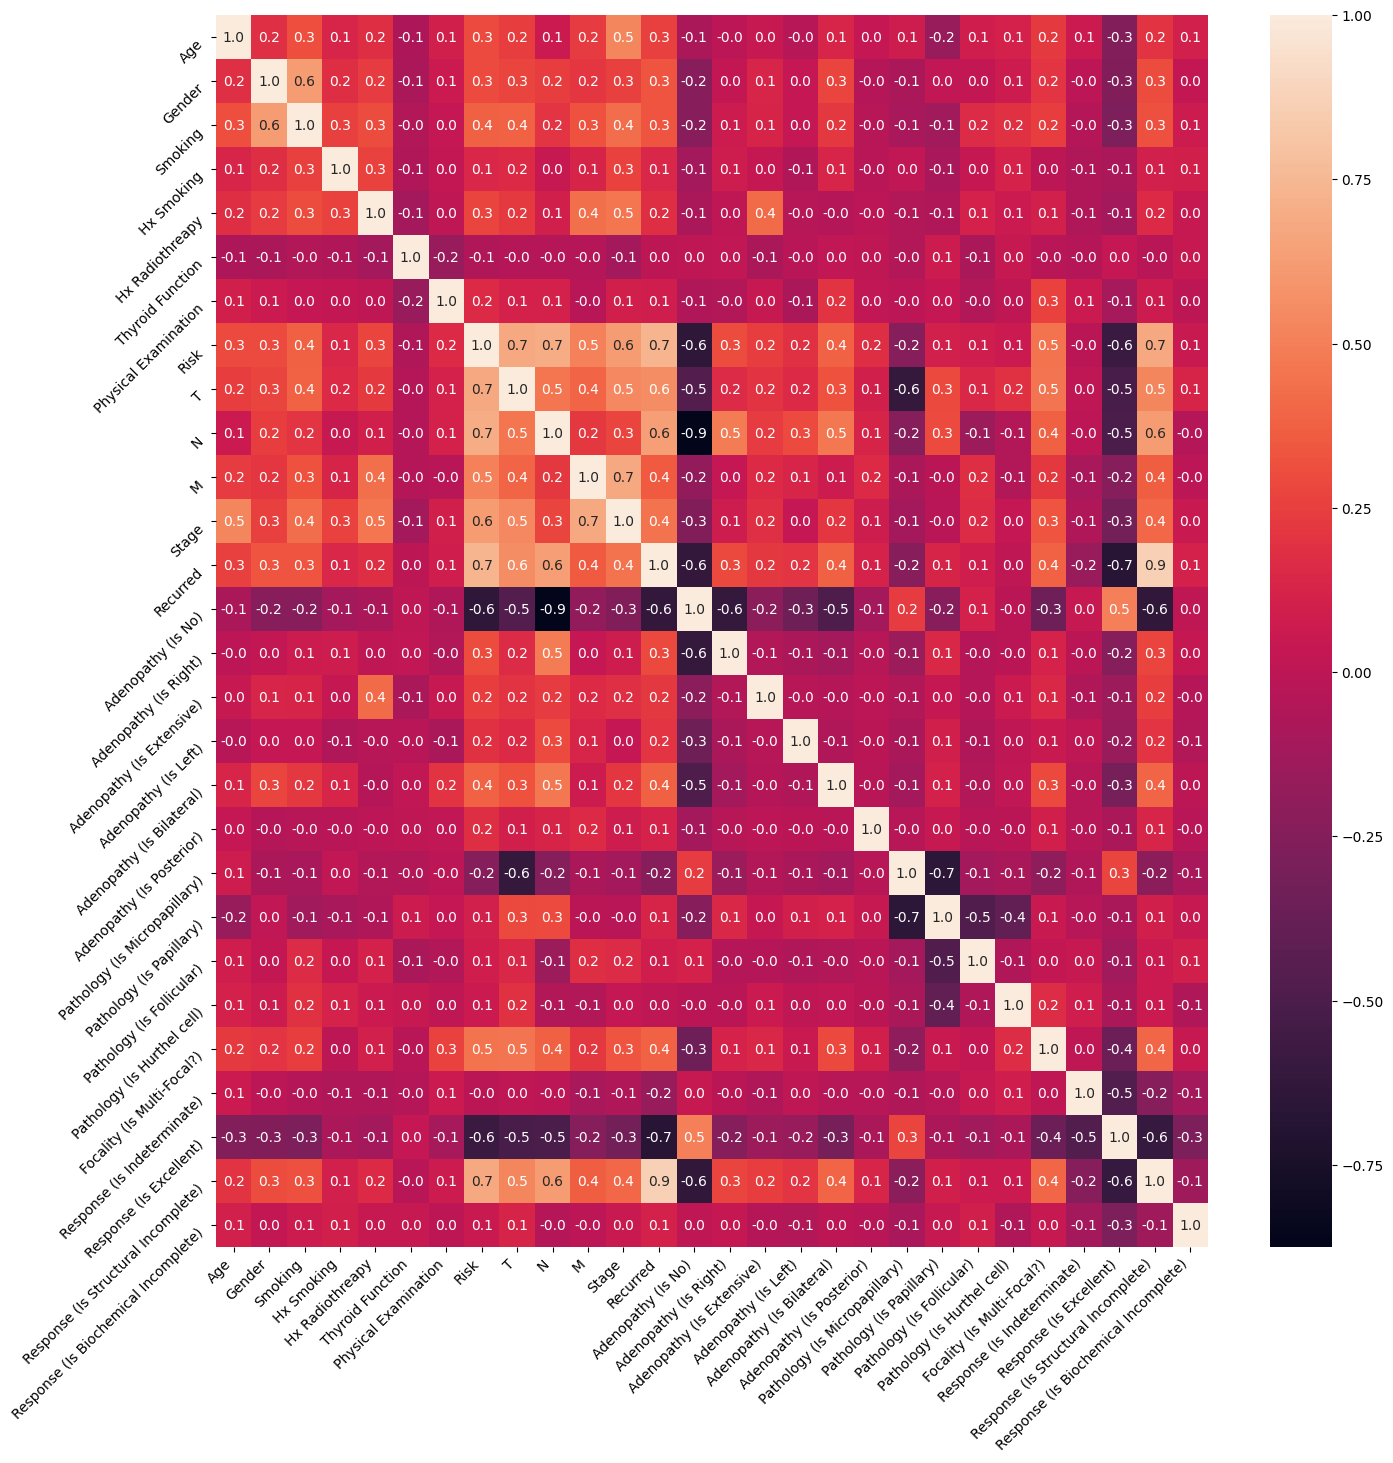

In [13]:

correlation_matrix = prepared_df.corr()

plt.figure(figsize=(16, 16))
sns.heatmap(correlation_matrix, annot=True, fmt=".1f", linewidths=0)
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=45, va="top")
plt.show()